In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import talib as tl
from sklearn.decomposition import PCA
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
train_size = 150
test_size = 10
return_day = 10
extreme_val = 0
full_size = train_size + test_size + return_day 
# make return_day long gap between train and test set to avoid lookahead bias

In [4]:
data = pd.read_excel('USDCLP.xlsx', skiprows=4, index_col='Dates', parse_dates=True)
data.dropna(inplace=True)
data.columns = ['Open', 'High', 'Low', 'Close']
data = data['2004':] # before 2004 the data is not OHLC, but C
data['2018-01-08':'2018-01-13']

,Open,High,Low,Close
Dates,,,,
2018-01-08,606.37,608.47,604.58,605.31
2018-01-09,606.00,608.59,605.57,607.89
2018-01-10,607.66,610.70,606.23,609.32
2018-01-11,608.01,609.67,606.13,606.22
2018-01-12,603.17,605.81,602.86,603.18


In [5]:
new_data = data.resample('1W').pad()
new_data['Open'] = data['Open'].resample('1W').first()
new_data['Close'] = data['Close'].resample('1W').last()
new_data['High'] = data['High'].resample('1W').max()
new_data['Low'] = data['Low'].resample('1W').min()
new_data.dropna(inplace=True)
new_data.tail()

,Open,High,Low,Close
Dates,,,,
2018-01-07,612.19,612.45,601.80,605.78
2018-01-14,606.37,610.70,602.86,603.18
2018-01-21,599.58,608.82,599.31,608.21
2018-01-28,607.69,609.78,597.70,601.68
2018-02-04,603.65,607.37,596.31,597.03


In [6]:
data = new_data

In [7]:
oopen = data['Open'].values
high = data['High'].values
low = data['Low'].values
close = data['Close'].values

In [8]:
features_to_delete = data.columns.tolist()

# ROC

In [9]:
for i in [2, 5, 10, 20]:
    data[f'ROC {i}'] = tl.ROC(close, timeperiod=i)

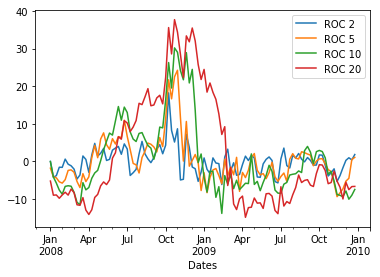

In [10]:
data['2008': '2009'][['ROC 2', 'ROC 5', 'ROC 10', 'ROC 20']].plot()

# Deviation from zero-lag exponential MA

In [11]:
for i in [10, 20, 40]:
    lag = (i-1)/2
    ema_data = 2*data['Close'] - data['Close'].shift(i).fillna(method='bfill')
    data['Deviation EMA ' + str(i)] = data['Close'] - tl.EMA(ema_data.values, timeperiod=i)

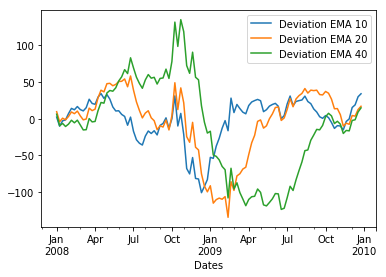

In [12]:
data['2008':'2009'][['Deviation EMA 10', 'Deviation EMA 20', 'Deviation EMA 40']].plot()

# MACD

In [13]:
for i, j, k in [(12, 16, 9), (3, 5, 2)]:
    macd, macdsignal, macdhist = tl.MACD(close, fastperiod=i, slowperiod=j, signalperiod=k)
    data[f'MACD ({i}, {j}, {k})'] = macd
#     data[f'MACD signal ({i}, {j}, {k})'] = macdsignal
#     data[f'MACD hist ({i}, {j}, {k})'] = macdhist

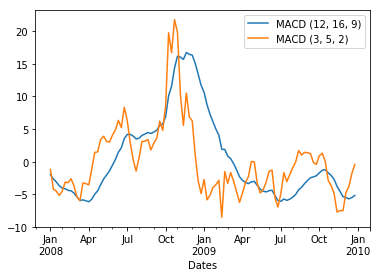

In [14]:
data['2008':'2009'][['MACD (12, 16, 9)', 'MACD (3, 5, 2)']].plot()

In [15]:
# data['2008'][['MACD signal (12, 16, 9)', 'MACD signal (3, 5, 2)']].plot()

In [16]:
# data['2008'][['MACD hist (14, 20, 12)', 'MACD hist (12, 16, 9)', 'MACD hist (3, 5, 2)']].plot()

# RSI

In [17]:
for i in [5, 10, 14, 20]:
    data[f'RSI {i}'] = tl.RSI(close, timeperiod=i)

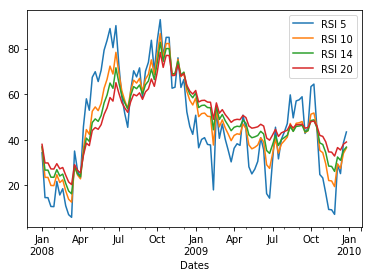

In [18]:
data['2008':'2009'][['RSI 5', 'RSI 10', 'RSI 14', 'RSI 20']].plot()

# SMA differences

In [19]:
for i, j in [(5, 10), (10, 20)]:
    data[f'SMA ({i}, {j}) diff'] = tl.SMA(close, timeperiod=i) - tl.SMA(close, timeperiod=j)

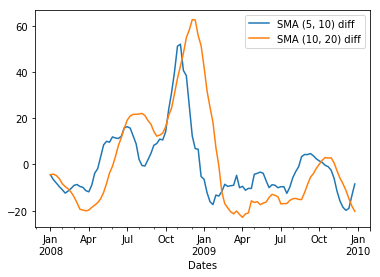

In [20]:
data['2008':'2009'][['SMA (5, 10) diff', 'SMA (10, 20) diff']].plot()

# ADX

In [21]:
data['ADX 14'] = tl.ADX(high, low, close, timeperiod=14)

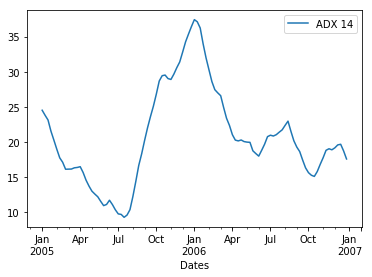

In [22]:
data['2005':'2006'][['ADX 14']].plot()

# CCI

In [23]:
data['CCI 14'] = tl.CCI(high, low, close, timeperiod=14)

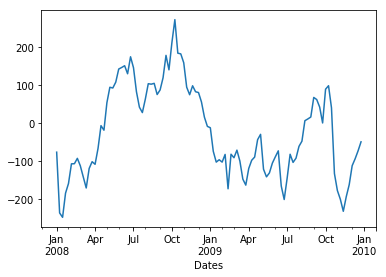

In [24]:
data['2008':'2009']['CCI 14'].plot()

# Y target value

In [25]:
data['Return'] = data['Close'].pct_change(return_day).shift(-return_day)*100
data['Extreme'] = 0 #data['Close'].pct_change(return_day).rolling(return_day).std()*100

In [26]:
data.dropna(inplace=True)
data.drop(columns=features_to_delete, inplace=True)
data.head()

,ROC 2,ROC 5,ROC 10,ROC 20,Deviation EMA 10,Deviation EMA 20,Deviation EMA 40,"MACD (12, 16, 9)","MACD (3, 5, 2)",RSI 5,RSI 10,RSI 14,RSI 20,"SMA (5, 10) diff","SMA (10, 20) diff",ADX 14,CCI 14,Return,Extreme
Dates,,,,,,,,,,,,,,,,,,,
2004-10-03,-0.950430,-3.565731,-4.773533,-5.258621,-3.145266,-33.071905,-39.414000,-1.063577,-3.861377,19.825401,34.272946,41.114504,46.984882,-11.395,-6.1890,23.131563,-149.550770,-1.968732,0
2004-10-10,-2.877405,-4.189450,-7.175132,-7.218502,-1.318854,-33.379343,-46.271854,-1.860784,-4.879007,14.557762,29.792533,37.437672,44.189530,-12.000,-8.4765,23.788964,-163.745237,-3.726395,0
2004-10-17,0.719663,-1.345001,-5.045621,-3.670886,15.480028,-16.183691,-34.079324,-1.949907,-2.230049,42.969704,42.352674,45.334744,48.982102,-10.425,-10.5515,23.417572,-96.015734,-7.769382,0
2004-10-24,2.182123,-0.245801,-4.830767,-5.576237,18.242751,-11.263816,-34.076674,-1.982963,-0.983722,42.901381,42.320443,45.311144,48.965143,-7.635,-11.8440,22.543811,-59.526914,-8.706366,0
2004-10-31,0.813075,0.057059,-2.818463,-5.431433,22.253160,-2.310119,-29.563178,-1.790757,0.429008,52.368375,46.817456,48.214271,50.759614,-5.785,-11.8615,21.732462,-39.499532,-7.046843,0


### Features

In [27]:
feature_names = data.drop(['Return', 'Extreme'], axis=1).columns

# Train and test Random Forest

In [28]:
def to_class(y_vec, extreme):
    pos = y_vec > extreme
    neg = y_vec <= -1*extreme

    y_vec[:] = 'Neutral'
    y_vec[pos] = 'Pos'
    y_vec[neg] = 'Neg'
    return y_vec

In [29]:
def make_X_y(df):
    X = df.drop(['Return', 'Extreme'], axis=1)
    y = df['Return'].copy()
    ret = y.copy()
    y = to_class(y, extreme_val)
    return X, y, ret

In [30]:
def split_X_y(X, y, ret):
    X_train = X.iloc[:train_size]
    X_test = X.iloc[-test_size:]
    y_train = y.iloc[:train_size]
    y_test = y.iloc[-test_size:]
    train_ret = ret.iloc[:train_size]
    test_ret = ret.iloc[-test_size:]
    print('Split result before upsampling: {} -> {} + {}'.format(len(X), len(X_train), len(X_test)))
    test_from_date, test_to_date = test_ret.index[0], test_ret.index[-1]
    print(f'Test period: from {test_from_date} to {test_to_date}')
    
    last_q4 = 50
    last_q8 = 25
    
    X_train = pd.concat([X_train, X_train[-last_q4:], X_train[-last_q8:]], ignore_index=True)
    y_train = pd.concat([y_train, y_train[-last_q4:], y_train[-last_q8:]], ignore_index=True)
    train_ret = pd.concat([train_ret, train_ret[-last_q4:], train_ret[-last_q8:]], ignore_index=True)
    
    return X_train, X_test, y_train, y_test, train_ret, test_ret

In [31]:
def print_labels_distrib(y_train, y_test):
    def distrib_print(vec):
        print('---\nDistribution:\n' + str(vec.value_counts()))
        
    distrib_print(y_train)
    distrib_print(y_test)

In [32]:
def calculate_returns(ret, y_pred, log=True):
    longs = np.nansum(ret[y_pred == 'Pos'])
    shorts = np.nansum(-1*ret[y_pred == 'Neg'])
    ret_sum = longs + shorts
    if log:
        print(f'{longs} [long] + {shorts} [short] = {ret_sum}')
        y_pred_s = pd.Series(y_pred, index=ret.index)
        return ret_sum, pd.concat([ret[y_pred == 'Pos'], -1*ret[y_pred == 'Neg']]), y_pred_s
    return ret_sum

In [33]:
from sklearn.metrics import make_scorer
def custom_loss(y_true, y_pred, ret):
#     bad_sum     = -8*np.sum(((y_true == 'Pos') & (y_pred == 'Neg')) | ((y_true == 'Neg') & (y_pred == 'Pos')))
#     np_sum      = -2*np.sum(((y_true == 'Neutral') & (y_pred == 'Pos')) | ((y_true == 'Neutral') & (y_pred == 'Neg')))
#     pn_sum      = -1*np.sum(((y_true == 'Pos') & (y_pred == 'Neutral')) | ((y_true == 'Neg') & (y_pred == 'Neutral')))
#     good_sum    =  10*np.sum(((y_true == 'Pos') & (y_pred == 'Pos')) | ((y_true == 'Neg') & (y_pred == 'Neg')))
#     return bad_sum + np_sum + pn_sum + good_sum
    actual_returns = ret.iloc[y_true.index]
    return calculate_returns(actual_returns, y_pred, log=False) 

In [34]:
def print_results(y_test, y_pred):
    print('---\nClassification report\n', classification_report(y_test, y_pred))
    print('---\nConfusion matrix\n', str(confusion_matrix(y_test, y_pred)))

## Train and Test

In [35]:
def train_and_test(df):
    X, y, ret = make_X_y(df)
    X_train, X_test, y_train, y_test, train_ret, test_ret = split_X_y(X, y, ret)
    print_labels_distrib(y_train, y_test)
    
    forest = RandomForestClassifier(n_jobs=8, oob_score=True, class_weight='balanced_subsample')
    pipe = Pipeline(steps=[('scaler', StandardScaler()), 
#                            ('pca', PCA()), 
                           ('forest', forest)])
    
    params = {'forest__n_estimators': [100],
              'forest__max_depth': [5, None],
              'forest__max_features': ['sqrt', None],
              'forest__min_samples_split': [2,5,10,20],
              'forest__min_samples_leaf': [2,5,10,20],
#               'pca__n_components': [0.3, 0.7],
             }
#     scorer = make_scorer(custom_loss, greater_is_better=True, ret=train_ret)
    grid = GridSearchCV(estimator=pipe,
                        param_grid=params, 
                        scoring='accuracy',
                        iid=False,
                        cv=5)
    
    grid.fit(X_train, y_train)
    best_estimator = grid.best_estimator_
    best_params = grid.best_params_
    
    y_pred = best_estimator.predict(X_test)
    print_results(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    ret_sum, trades, y_pred_s = calculate_returns(test_ret, y_pred)
    
    param = {
        'accuracy':acc,
        'date': df.index[-1],
        'best_params': best_params,
#         'features': best_estimator.steps[-1][1].feature_importances_,
        'ret_sum': ret_sum,
        'trades': trades,
        'predictions': y_pred_s
    }
    test_params.append(param)

In [36]:
test_params = []

for i in range(0, len(data)-full_size, test_size):
    sub_data = data.iloc[i:i+full_size]
    from_date, to_date = sub_data.index[0], sub_data.index[-1]
    sep = 100*'='
    print(f'{sep}\nFrom {from_date} to {to_date}')
    train_and_test(sub_data)

From 2004-10-03 00:00:00 to 2007-12-30 00:00:00
Split result before upsampling: 170 -> 150 + 10
Test period: from 2007-10-28 00:00:00 to 2007-12-30 00:00:00
---
Distribution:
Neg    163
Pos     62
Name: Return, dtype: int64
---
Distribution:
Neg    10
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      0.70      0.82        10
        Pos       0.00      0.00      0.00         0

avg / total       1.00      0.70      0.82        10

---
Confusion matrix
 [[7 3]
 [0 0]]
-17.687957656699005 [long] + 48.33983711929564 [short] = 30.651879462596632
From 2004-12-12 00:00:00 to 2008-03-09 00:00:00
Split result before upsampling: 170 -> 150 + 10
Test period: from 2008-01-06 00:00:00 to 2008-03-09 00:00:00
---
Distribution:
Neg    166
Pos     59
Name: Return, dtype: int64
---
Distribution:
Neg    7
Pos    3
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.70      1.00      0.82         7
        Pos       0.00      0.00      0.00         3

avg / total       0.49      0.70      0.58        10

---
Confusion matrix
 [[7 0]
 [3 0]]
0.0 [long] + 33.81954747311243 [short] = 33.81954747311243
From 2005-02-20 00:00:00 to 2008-05-18 00:00:00
Split result before upsampling: 170 -> 150 + 10
Test period: from 2008-03-16 00:00:00 to 2008-05-18 00:00:00
---
Distribution:
Neg    183
Pos     42
Name: Return, dtype: int64
---
Distribution:
Pos    10
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
        Pos       1.00      0.20      0.33        10

avg / total       1.00      0.20      0.33        10

---
Confusion matrix
 [[0 0]
 [8 2]]
25.296393439695628 [long] + -71.44795968769219 [short] = -46.15156624799656
From 2005-05-01 00:00:00 to 2008-07-27 00:00:00
Split result before upsampling: 170 -> 150 + 10
Test period: from 2008-05-25 00:00:00 to 2008-07-27 00:00:00
---
Distribution:
Neg    179
Pos     46
Name: Return, dtype: int64
---
Distribution:
Pos    10
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
        Pos       0.00      0.00      0.00        10

avg / total       0.00      0.00      0.00        10

---
Confusion matrix
 [[ 0  0]
 [10  0]]
0.0 [long] + -66.52495670382538 [short] = -66.52495670382538
From 2005-07-10 00:00:00 to 2008-10-05 00:00:00
Split result before upsampling: 170 -> 150 + 10
Test period: from 2008-08-03 00:00:00 to 2008-10-05 00:00:00
---
Distribution:
Neg    152
Pos     73
Name: Return, dtype: int64
---
Distribution:
Pos    10
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
        Pos       0.00      0.00      0.00        10

avg / total       0.00      0.00      0.00        10

---
Confusion matrix
 [[ 0  0]
 [10  0]]
0.0 [long] + -238.47728012352502 [short] = -238.47728012352502
From 2005-09-18 00:00:00 to 2008-12-14 00:00:00
Split result before upsampling: 170 -> 150 + 10
Test period: from 2008-10-12 00:00:00 to 2008-12-14 00:00:00
---
Distribution:
Neg    123
Pos    102
Name: Return, dtype: int64
---
Distribution:
Neg    9
Pos    1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         9
        Pos       0.10      1.00      0.18         1

avg / total       0.01      0.10      0.02        10

---
Confusion matrix
 [[0 9]
 [0 1]]
-50.82812140963442 [long] + 0.0 [short] = -50.82812140963442
From 2005-11-27 00:00:00 to 2009-02-22 00:00:00
Split result before upsampling: 170 -> 150 + 10
Test period: from 2008-12-21 00:00:00 to 2009-02-22 00:00:00
---
Distribution:
Pos    123
Neg    102
Name: Return, dtype: int64
---
Distribution:
Neg    9
Pos    1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         9
        Pos       0.10      1.00      0.18         1

avg / total       0.01      0.10      0.02        10

---
Confusion matrix
 [[0 9]
 [0 1]]
-52.60022548929596 [long] + 0.0 [short] = -52.60022548929596
From 2006-02-05 00:00:00 to 2009-05-03 00:00:00
Split result before upsampling: 170 -> 150 + 10
Test period: from 2009-03-01 00:00:00 to 2009-05-03 00:00:00
---
Distribution:
Neg    117
Pos    108
Name: Return, dtype: int64
---
Distribution:
Neg    10
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      0.60      0.75        10
        Pos       0.00      0.00      0.00         0

avg / total       1.00      0.60      0.75        10

---
Confusion matrix
 [[6 4]
 [0 0]]
-22.767442243962567 [long] + 34.82697219526377 [short] = 12.059529951301204
From 2006-04-16 00:00:00 to 2009-07-12 00:00:00
Split result before upsampling: 170 -> 150 + 10
Test period: from 2009-05-10 00:00:00 to 2009-07-12 00:00:00
---
Distribution:
Neg    130
Pos     95
Name: Return, dtype: int64
---
Distribution:
Neg    7
Pos    3
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      0.43      0.60         7
        Pos       0.43      1.00      0.60         3

avg / total       0.83      0.60      0.60        10

---
Confusion matrix
 [[3 4]
 [0 3]]
-1.0754897582402996 [long] + 12.425439962825578 [short] = 11.349950204585278
Fr

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         2
        Pos       0.80      1.00      0.89         8

avg / total       0.64      0.80      0.71        10

---
Confusion matrix
 [[0 2]
 [0 8]]
33.81363599933981 [long] + 0.0 [short] = 33.81363599933981
From 2007-01-21 00:00:00 to 2010-04-18 00:00:00
Split result before upsampling: 170 -> 150 + 10
Test period: from 2010-02-14 00:00:00 to 2010-04-18 00:00:00
---
Distribution:
Neg    158
Pos     67
Name: Return, dtype: int64
---
Distribution:
Pos    8
Neg    2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         2
        Pos       0.80      1.00      0.89         8

avg / total       0.64      0.80      0.71        10

---
Confusion matrix
 [[0 2]
 [0 8]]
18.723804123724264 [long] + 0.0 [short] = 18.723804123724264
From 2007-04-01 00:00:00 to 2010-06-27 00:00:00
Split result before upsampling: 170 -> 150 + 10
Test period: from 2010-04-25 00:00:00 to 2010-06-27 00:00:00
---
Distribution:
Neg    142
Pos     83
Name: Return, dtype: int64
---
Distribution:
Neg    8
Pos    2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         8
        Pos       0.20      1.00      0.33         2

avg / total       0.04      0.20      0.07        10

---
Confusion matrix
 [[0 8]
 [0 2]]
-29.660327759784334 [long] + 0.0 [short] = -29.660327759784334
From 2007-06-10 00:00:00 to 2010-09-05 00:00:00
Split result before upsampling: 170 -> 150 + 10
Test period: from 2010-07-04 00:00:00 to 2010-09-05 00:00:00
---
Distribution:
Neg    119
Pos    106
Name: Return, dtype: int64
---
Distribution:
Neg    10
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      0.70      0.82        10
        Pos       0.00      0.00      0.00         0

avg / total       1.00      0.70      0.82        10

---
Confusion matrix
 [[7 3]
 [0 0]]
-23.228641674436833 [long] + 36.66895633112025 [short] = 13.440314656683416
From 2007-08-19 00:00:00 to 2010-11-14 00:00:00
Split result before upsampling: 170 -> 150 + 10
Test period: from 2010-09-12 00:00:00 to 2010-11-14 00:00:00
---
Distribution:
Neg    124
Pos    101
Name: Return, dtype: int64
---
Distribution:
Neg    7
Pos    3
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       0.67      0.86      0.75         7
        Pos       0.00      0.00      0.00         3

avg / total       0.47      0.60      0.53        10

---
Confusion matrix
 [[6 1]
 [3 0]]
-1.9425781413011767 [long] + 8.188164209881702 [short] = 6.245586068580526
From

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      0.10      0.18        10
        Pos       0.00      0.00      0.00         0

avg / total       1.00      0.10      0.18        10

---
Confusion matrix
 [[1 9]
 [0 0]]
-18.274063095869366 [long] + 1.7190291058106544 [short] = -16.55503399005871
From 2008-03-16 00:00:00 to 2011-06-12 00:00:00
Split result before upsampling: 170 -> 150 + 10
Test period: from 2011-04-10 00:00:00 to 2011-06-12 00:00:00
---
Distribution:
Neg    134
Pos     91
Name: Return, dtype: int64
---
Distribution:
Neg    5
Pos    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.50      1.00      0.67         5
        Pos       0.00      0.00      0.00         5

avg / total       0.25      0.50      0.33        10

---
Confusion matrix
 [[5 0]
 [5 0]]
0.0 [long] + 2.8062279588755508 [short] = 2.8062279588755508
From 2008-05-25 00:00:00 to 2011-08-21 00:00:00
Split result before upsampling: 170 -> 150 + 10
Test period: from 2011-06-19 00:00:00 to 2011-08-21 00:00:00
---
Distribution:
Neg    152
Pos     73
Name: Return, dtype: int64
---
Distribution:
Pos    8
Neg    2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.20      1.00      0.33         2
        Pos       0.00      0.00      0.00         8

avg / total       0.04      0.20      0.07        10

---
Confusion matrix
 [[2 0]
 [8 0]]
0.0 [long] + -59.515897736652946 [short] = -59.515897736652946
From 2008-08-03 00:00:00 to 2011-10-30 00:00:00
Split result before upsampling: 170 -> 150 + 10
Test period: from 2011-08-28 00:00:00 to 2011-10-30 00:00:00
---
Distribution:
Neg    154
Pos     71
Name: Return, dtype: int64
---
Distribution:
Pos    7
Neg    3
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       0.33      0.67      0.44         3
        Pos       0.75      0.43      0.55         7

avg / total       0.62      0.50      0.52        10

---
Confusion matrix
 [[2 1]
 [4 3]]
13.383804160074318 [long] + -26.68293375755276 [short] = -13.299129597478442
From 2008-10-12

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.90      1.00      0.95         9
        Pos       0.00      0.00      0.00         1

avg / total       0.81      0.90      0.85        10

---
Confusion matrix
 [[9 0]
 [1 0]]
0.0 [long] + 52.68946295900066 [short] = 52.68946295900066
From 2008-12-21 00:00:00 to 2012-03-18 00:00:00
Split result before upsampling: 170 -> 150 + 10
Test period: from 2012-01-15 00:00:00 to 2012-03-18 00:00:00
---
Distribution:
Neg    128
Pos     97
Name: Return, dtype: int64
---
Distribution:
Pos    6
Neg    4
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.40      1.00      0.57         4
        Pos       0.00      0.00      0.00         6

avg / total       0.16      0.40      0.23        10

---
Confusion matrix
 [[4 0]
 [6 0]]
0.0 [long] + -10.432040158410416 [short] = -10.432040158410416
From 2009-03-01 00:00:00 to 2012-05-27 00:00:00
Split result before upsampling: 170 -> 150 + 10
Test period: from 2012-03-25 00:00:00 to 2012-05-27 00:00:00
---
Distribution:
Neg    135
Pos     90
Name: Return, dtype: int64
---
Distribution:
Pos    8
Neg    2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.20      1.00      0.33         2
        Pos       0.00      0.00      0.00         8

avg / total       0.04      0.20      0.07        10

---
Confusion matrix
 [[2 0]
 [8 0]]
0.0 [long] + -14.004342965246728 [short] = -14.004342965246728
From 2009-05-10 00:00:00 to 2012-08-05 00:00:00
Split result before upsampling: 170 -> 150 + 10
Test period: from 2012-06-03 00:00:00 to 2012-08-05 00:00:00
---
Distribution:
Neg    126
Pos     99
Name: Return, dtype: int64
---
Distribution:
Neg    10
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      1.00      1.00        10

avg / total       1.00      1.00      1.00        10

---
Confusion matrix
 [[10]]
0.0 [long] + 40.71155796314453 [short] = 40.71155796314453
From 2009-07-19 00:00:00 to 2012-10-14 00:00:00
Split result before upsampling: 170 -> 150 + 10
Test p

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.60      1.00      0.75         6
        Pos       0.00      0.00      0.00         4

avg / total       0.36      0.60      0.45        10

---
Confusion matrix
 [[6 0]
 [4 0]]
0.0 [long] + 2.0299927923137395 [short] = 2.0299927923137395
From 2010-02-14 00:00:00 to 2013-05-12 00:00:00
Split result before upsampling: 170 -> 150 + 10
Test period: from 2013-03-10 00:00:00 to 2013-05-12 00:00:00
---
Distribution:
Neg    138
Pos     87
Name: Return, dtype: int64
---
Distribution:
Pos    10
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
        Pos       1.00      0.10      0.18        10

avg / total       1.00      0.10      0.18        10

---
Confusion matrix
 [[0 0]
 [9 1]]
5.032519458364426 [long] + -54.1193758732937 [short] = -49.08685641492927
From 2010-04-25 00:00:00 to 2013-07-21 00:00:00
Split result before upsampling: 170 -> 150 + 10
Test period: from 2013-05-19 00:00:00 to 2013-07-21 00:00:00
---
Distribution:
Neg    141
Pos     84
Name: Return, dtype: int64
---
Distribution:
Pos    6
Neg    4
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.40      1.00      0.57         4
        Pos       0.00      0.00      0.00         6

avg / total       0.16      0.40      0.23        10

---
Confusion matrix
 [[4 0]
 [6 0]]
0.0 [long] + -14.786899863954282 [short] = -14.786899863954282
From 2010-07-04 00:00:00 to 2013-09-29 00:00:00
Split result before upsampling: 170 -> 150 + 10
Test period: from 2013-07-28 00:00:00 to 2013-09-29 00:00:00
---
Distribution:
Neg    127
Pos     98
Name: Return, dtype: int64
---
Distribution:
Pos    6
Neg    4
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.40      1.00      0.57         4
        Pos       0.00      0.00      0.00         6

avg / total       0.16      0.40      0.23        10

---
Confusion matrix
 [[4 0]
 [6 0]]
0.0 [long] + -12.359111037372106 [short] = -12.359111037372106
From 2010-09-12 00:00:00 to 2013-12-08 00:00:00
Split result before upsampling: 170 -> 150 + 10
Test period: from 2013-10-06 00:00:00 to 2013-12-08 00:00:00
---
Distribution:
Pos    114
Neg    111
Name: Return, dtype: int64
---
Distribution:
Pos    10
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
        Pos       1.00      0.20      0.33        10

avg / total       1.00      0.20      0.33        10

---
Confusion matrix
 [[0 0]
 [8 2]]
11.05101659976484 [long] + -39.008399904843195 [short] = -27.957383305078356
From 2010-11-21 00:00:00 to 2014-02-16 00:00:00
Split result before upsampling: 170 -> 150 + 10
Test period: from 2013-12-15 00:00:00 to 2014-02-16 00:00:00
---
Distribution:
Pos    116
Neg    109
Name: Return, dtype: int64
---
Distribution:
Pos    9
Neg    1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.10      1.00      0.18         1
        Pos       0.00      0.00      0.00         9

avg / total       0.01      0.10      0.02        10

---
Confusion matrix
 [[1 0]
 [9 0]]
0.0 [long] + -36.9421294633883 [short] = -36.9421294633883
From 2011-01-30 00:00:00 to 2014-04-27 00:00:00
Split result before upsampling: 170 -> 150 + 10
Test period: from 2014-02-23 00:00:00 to 2014-04-27 00:00:00
---
Distribution:
Pos    131
Neg     94
Name: Return, dtype: int64
---
Distribution:
Neg    7
Pos    3
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       0.67      0.57      0.62         7
        Pos       0.25      0.33      0.29         3

avg / total       0.54      0.50      0.52        10

---
Confusion matrix
 [[4 3]
 [2 1]]
-1.8123121814051735 [long] + 7.022648773800999 [short] = 5.210336592395825
From 2011-04-10 00:00

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
        Pos       0.90      1.00      0.95         9

avg / total       0.81      0.90      0.85        10

---
Confusion matrix
 [[0 1]
 [0 9]]
40.81679287098581 [long] + 0.0 [short] = 40.81679287098581
From 2011-06-19 00:00:00 to 2014-09-14 00:00:00
Split result before upsampling: 170 -> 150 + 10
Test period: from 2014-07-13 00:00:00 to 2014-09-14 00:00:00
---
Distribution:
Pos    136
Neg     89
Name: Return, dtype: int64
---
Distribution:
Pos    9
Neg    1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
        Pos       0.90      1.00      0.95         9

avg / total       0.81      0.90      0.85        10

---
Confusion matrix
 [[0 1]
 [0 9]]
26.465633203827842 [long] + 0.0 [short] = 26.465633203827842
From 2011-08-28 00:00:00 to 2014-11-23 00:00:00
Split result before upsampling: 170 -> 150 + 10
Test period: from 2014-09-21 00:00:00 to 2014-11-23 00:00:00
---
Distribution:
Pos    139
Neg     86
Name: Return, dtype: int64
---
Distribution:
Pos    10
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
        Pos       1.00      0.20      0.33        10

avg / total       1.00      0.20      0.33        10

---
Confusion matrix
 [[0 0]
 [8 2]]
13.194076772398189 [long] + -31.572140640764502 [short] = -18.37806386836631
From 2011-11-06 00:00:00 to 2015-02-01 00:00:00
Split result before upsampling: 170 -> 150 + 10
Test period: from 2014-11-30 00:00:00 to 2015-02-01 00:00:00
---
Distribution:
Pos    148
Neg     77
Name: Return, dtype: int64
---
Distribution:
Pos    6
Neg    4
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      0.75      0.86         4
        Pos       0.86      1.00      0.92         6

avg / total       0.91      0.90      0.90        10

---
Confusion matrix
 [[3 1]
 [0 6]]
15.162394849384253 [long] + 4.737893564851026 [short] = 19.900288414235277
Fro

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         7
        Pos       0.30      1.00      0.46         3

avg / total       0.09      0.30      0.14        10

---
Confusion matrix
 [[0 7]
 [0 3]]
-11.231889237980306 [long] + 0.0 [short] = -11.231889237980306
From 2012-03-25 00:00:00 to 2015-06-21 00:00:00
Split result before upsampling: 170 -> 150 + 10
Test period: from 2015-04-19 00:00:00 to 2015-06-21 00:00:00
---
Distribution:
Pos    154
Neg     71
Name: Return, dtype: int64
---
Distribution:
Pos    10
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Pos       1.00      1.00      1.00        10

avg / total       1.00      1.00      1.00        10

---
Confusion matrix
 [[10]]
78.29101006151376 [long] + 0.0 [short] = 78.29101006151376
From 2012-06-03 00:00:00 to 2015-08-30 00:00:00
Split result before upsampling: 170 -> 150 + 10
Test p

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
        Pos       1.00      0.20      0.33        10

avg / total       1.00      0.20      0.33        10

---
Confusion matrix
 [[0 0]
 [8 2]]
6.771693049618155 [long] + -25.528445848026337 [short] = -18.756752798408183
From 2012-10-21 00:00:00 to 2016-01-17 00:00:00
Split result before upsampling: 170 -> 150 + 10
Test period: from 2015-11-15 00:00:00 to 2016-01-17 00:00:00
---
Distribution:
Pos    162
Neg     63
Name: Return, dtype: int64
---
Distribution:
Neg    7
Pos    3
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       0.57      0.57      0.57         7
        Pos       0.00      0.00      0.00         3

avg / total       0.40      0.40      0.40        10

---
Confusion matrix
 [[4 3]
 [3 0]]
-7.43190992950189 [long] + 14.017265295435443 [short] = 6.5853553659335535
Fro

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         6
        Pos       0.40      1.00      0.57         4

avg / total       0.16      0.40      0.23        10

---
Confusion matrix
 [[0 6]
 [0 4]]
-26.144792509840226 [long] + 0.0 [short] = -26.144792509840226
From 2013-03-10 00:00:00 to 2016-06-05 00:00:00
Split result before upsampling: 170 -> 150 + 10
Test period: from 2016-04-03 00:00:00 to 2016-06-05 00:00:00
---
Distribution:
Pos    162
Neg     63
Name: Return, dtype: int64
---
Distribution:
Neg    7
Pos    3
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         7
        Pos       0.30      1.00      0.46         3

avg / total       0.09      0.30      0.14        10

---
Confusion matrix
 [[0 7]
 [0 3]]
-19.0156760147316 [long] + 0.0 [short] = -19.0156760147316
From 2013-05-19 00:00:00 to 2016-08-14 00:00:00
Split result before upsampling: 170 -> 150 + 10
Test period: from 2016-06-12 00:00:00 to 2016-08-14 00:00:00
---
Distribution:
Pos    153
Neg     72
Name: Return, dtype: int64
---
Distribution:
Pos    7
Neg    3
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         3
        Pos       0.70      1.00      0.82         7

avg / total       0.49      0.70      0.58        10

---
Confusion matrix
 [[0 3]
 [0 7]]
6.068862624868688 [long] + 0.0 [short] = 6.068862624868688
From 2013-07-28 00:00:00 to 2016-10-23 00:00:00
Split result before upsampling: 170 -> 150 + 10
Test period: from 2016-08-21 00:00:00 to 2016-10-23 00:00:00
---
Distribution:
Pos    138
Neg     87
Name: Return, dtype: int64
---
Distribution:
Pos    6
Neg    4
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         4
        Pos       0.60      1.00      0.75         6

avg / total       0.36      0.60      0.45        10

---
Confusion matrix
 [[0 4]
 [0 6]]
0.61468978410254 [long] + 0.0 [short] = 0.61468978410254
From 2013-10-06 00:00:00 to 2017-01-01 00:00:00
Split result before upsampling: 170 -> 150 + 10
Test period: from 2016-10-30 00:00:00 to 2017-01-01 00:00:00
---
Distribution:
Pos    145
Neg     80
Name: Return, dtype: int64
---
Distribution:
Neg    8
Pos    2
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      0.12      0.22         8
        Pos       0.22      1.00      0.36         2

avg / total       0.84      0.30      0.25        10

---
Confusion matrix
 [[1 7]
 [0 2]]
-20.041266326280958 [long] + 1.8465675655486735 [short] = -18.194698760732283
From 2013-12-15 00:0

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
        Pos       0.90      1.00      0.95         9

avg / total       0.81      0.90      0.85        10

---
Confusion matrix
 [[0 1]
 [0 9]]
14.57225335843294 [long] + 0.0 [short] = 14.57225335843294
From 2014-02-23 00:00:00 to 2017-05-21 00:00:00
Split result before upsampling: 170 -> 150 + 10
Test period: from 2017-03-19 00:00:00 to 2017-05-21 00:00:00
---
Distribution:
Pos    128
Neg     97
Name: Return, dtype: int64
---
Distribution:
Pos    6
Neg    4
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.40      1.00      0.57         4
        Pos       0.00      0.00      0.00         6

avg / total       0.16      0.40      0.23        10

---
Confusion matrix
 [[4 0]
 [6 0]]
0.0 [long] + -0.765349751556732 [short] = -0.765349751556732
From 2014-05-04 00:00:00 to 2017-07-30 00:00:00
Split result before upsampling: 170 -> 150 + 10
Test period: from 2017-05-28 00:00:00 to 2017-07-30 00:00:00
---
Distribution:
Pos    141
Neg     84
Name: Return, dtype: int64
---
Distribution:
Neg    10
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      0.70      0.82        10
        Pos       0.00      0.00      0.00         0

avg / total       1.00      0.70      0.82        10

---
Confusion matrix
 [[7 3]
 [0 0]]
-10.157755320851258 [long] + 32.06519823535001 [short] = 21.907442914498752
From 2014-07-13 00:00:00 to 2017-10-08 00:00:00
Split result before upsampling: 170 -> 150 + 10
Test period: from 2017-08-06 00:00:00 to 2017-10-08 00:00:00
---
Distribution:
Pos    141
Neg     84
Name: Return, dtype: int64
---
Distribution:
Pos    6
Neg    4
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         4
        Pos       0.56      0.83      0.67         6

avg / total       0.33      0.50      0.40        10

---
Confusion matrix
 [[0 4]
 [1 5]]
1.1599904967575023 [long] + -0.5690709916062131 [short] = 0.5909195051512892


In [37]:
indexes = [d['date'] for d in test_params]

### Random Forest parameters with Accuracy and Returns

In [38]:
params = pd.DataFrame([d['best_params'] for d in test_params], index=indexes)
params['Sum of return'] = [d['ret_sum'] for d in test_params]
params['Accuracy'] = [d['accuracy'] for d in test_params]

In [39]:
params.sort_values('Sum of return', ascending=False)

,forest__max_depth,forest__max_features,forest__min_samples_leaf,forest__min_samples_split,forest__n_estimators,Sum of return,Accuracy
2015-06-21,NaN,sqrt,2,10,100,78.291010,1.0
2009-11-29,NaN,None,2,10,100,56.493402,0.8
2012-01-08,NaN,sqrt,2,5,100,52.689463,0.9
2009-09-20,NaN,sqrt,2,5,100,46.041424,0.9
2014-07-06,5.0,None,2,2,100,40.816793,0.9
2012-08-05,NaN,sqrt,2,5,100,40.711558,1.0
2008-03-09,NaN,sqrt,2,2,100,33.819547,0.7
2010-02-07,NaN,None,2,2,100,33.813636,0.8
2007-12-30,5.0,None,2,10,100,30.651879,0.7
2014-09-14,5.0,sqrt,2,2,100,26.465633,0.9


In [40]:
params.describe()

,forest__max_depth,forest__min_samples_leaf,forest__min_samples_split,forest__n_estimators,Sum of return,Accuracy
count,9.0,52.000000,52.000000,52.0,52.000000,52.000000
mean,5.0,2.923077,4.942308,100.0,-4.952883,0.490385
std,0.0,3.541608,4.556458,0.0,45.077595,0.283715
min,5.0,2.000000,2.000000,100.0,-238.477280,0.000000
25%,5.0,2.000000,2.000000,100.0,-18.472736,0.200000
50%,5.0,2.000000,3.500000,100.0,0.882272,0.500000
75%,5.0,2.000000,5.000000,100.0,16.165970,0.700000
max,5.0,20.000000,20.000000,100.0,78.291010,1.000000


In [41]:
params['Sum of return'].sum()

-257.54989099762327

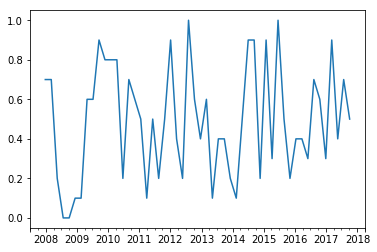

In [42]:
params['Accuracy'].plot()

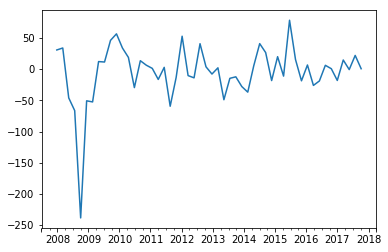

In [43]:
params['Sum of return'].plot()

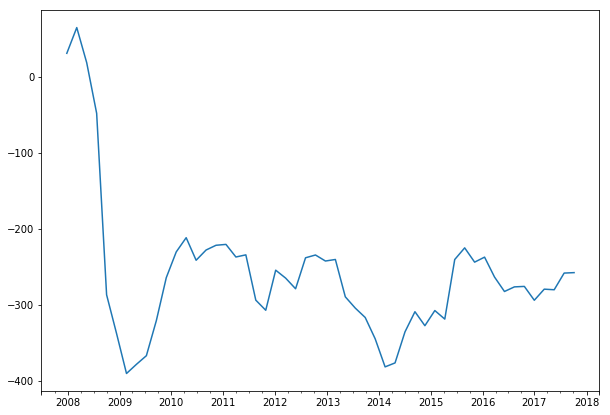

In [44]:
params['Sum of return'].cumsum().plot(figsize=(10,7))

#### Trades

In [45]:
all_trades = pd.concat([d['trades'] for d in test_params])

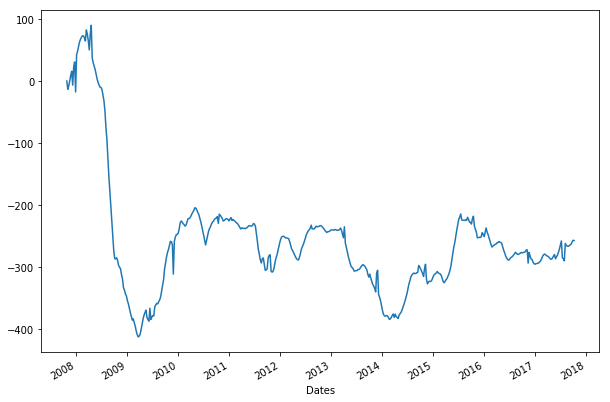

In [46]:
all_trades.cumsum().plot(figsize=(10,7))

### Feature importances

In [47]:
assert 'features' in test_params[0]

AssertionError: 

In [ ]:
features = pd.DataFrame([d['features'] for d in test_params], index=indexes, columns=feature_names)

In [ ]:
features.idxmax(axis=1).value_counts()

In [ ]:
plt.figure(figsize=(15,8))
sns.heatmap(features)

In [ ]:
plt.figure(figsize=(10,20))
sns.violinplot(data=features, orient='h')